# Image classification

## Data preprocessing

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

### Get the dataset

In [2]:
training_dir = 'dataset/training'
validation_dir = 'dataset/validation'
test_dir = 'dataset/test'

BATCH_SIZE = 32
IMG_SIZE = (150, 150)

In [3]:
training_dataset = tf.keras.utils.image_dataset_from_directory(training_dir,
                                                               shuffle=True,
                                                               label_mode='categorical',
                                                               batch_size=BATCH_SIZE,
                                                               image_size=IMG_SIZE)

Found 13140 files belonging to 6 classes.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 label_mode='categorical',
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2580 files belonging to 6 classes.


### Explore the training dataset

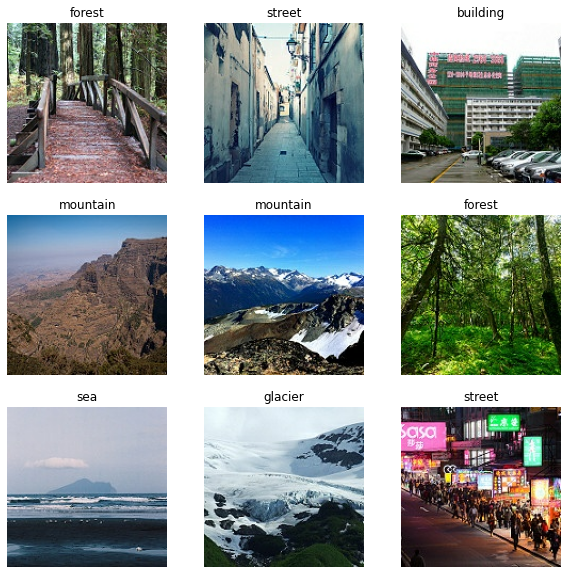

In [5]:
class_names = training_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in training_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

### Data augmentation

When we don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Let's repeatedly apply these layers to the same image and see the result.

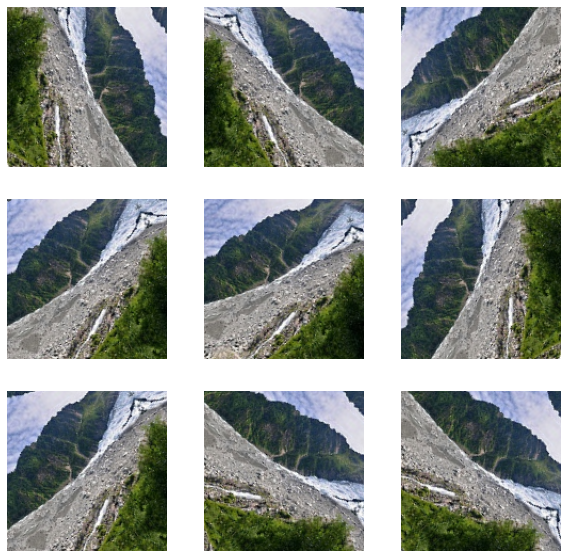

In [7]:
for image, _ in training_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Model building

### Rescale pixel values

We will use `tf.keras.applications.MobileNetV2` as our base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

### Creation of the base model using a CNN architecture

In [9]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

In [10]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image.

In [12]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')

Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional).

In [13]:
inputs = tf.keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model (Feature extraction)

In [14]:
from tensorflow.keras.optimizers import Adam

base_learning_rate = 0.0001

opt = Adam(learning_rate=base_learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer = opt,
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [16]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

81/81 [==============================] - 15s 169ms/step - loss: 2.3160 - accuracy: 0.1453
initial loss: 2.32
initial accuracy: 0.15


### Model training

In [17]:
history = model.fit(training_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
411/411 [==============================] - 97s 228ms/step - loss: 1.2180 - accuracy: 0.5419 - val_loss: 0.6460 - val_accuracy: 0.7872
Epoch 2/10
411/411 [==============================] - 95s 231ms/step - loss: 0.6609 - accuracy: 0.7599 - val_loss: 0.4609 - val_accuracy: 0.8442
Epoch 3/10
411/411 [==============================] - 96s 233ms/step - loss: 0.5480 - accuracy: 0.7990 - val_loss: 0.4098 - val_accuracy: 0.8597
Epoch 4/10
411/411 [==============================] - 95s 230ms/step - loss: 0.4980 - accuracy: 0.8186 - val_loss: 0.3717 - val_accuracy: 0.8682
Epoch 5/10
411/411 [==============================] - 95s 231ms/step - loss: 0.4671 - accuracy: 0.8299 - val_loss: 0.3528 - val_accuracy: 0.8760
Epoch 6/10
411/411 [==============================] - 99s 241ms/step - loss: 0.4444 - accuracy: 0.8364 - val_loss: 0.3353 - val_accuracy: 0.8822
Epoch 7/10
411/411 [==============================] - 97s 236ms/step - loss: 0.4365 - accuracy: 0.8409 - val_loss: 0.3325 - val_ac

### Fine tuning

In [18]:
base_model.trainable = True

fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

### Recompile the model

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

### Continue training the model
This time we will save the model for future usage.

In [31]:
checkpoint_filepath = 'model/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=True,
                                                               monitor='val_accuracy',
                                                               mode='max',
                                                               save_best_only=True)

In [32]:
fine_tuning_epochs = 10

total_epochs =  initial_epochs + fine_tuning_epochs

model.fit(training_dataset,
          epochs=total_epochs,
          initial_epoch=history.epoch[-1],
          validation_data=validation_dataset,
          callbacks=[model_checkpoint_callback])

Epoch 10/20
411/411 [==============================] - 164s 400ms/step - loss: 0.1708 - accuracy: 0.9355 - val_loss: 0.2090 - val_accuracy: 0.9159
Epoch 11/20
411/411 [==============================] - 163s 396ms/step - loss: 0.1683 - accuracy: 0.9369 - val_loss: 0.2110 - val_accuracy: 0.9205
Epoch 12/20
411/411 [==============================] - 160s 389ms/step - loss: 0.1698 - accuracy: 0.9383 - val_loss: 0.2142 - val_accuracy: 0.9167
Epoch 13/20
411/411 [==============================] - 159s 386ms/step - loss: 0.1625 - accuracy: 0.9405 - val_loss: 0.2105 - val_accuracy: 0.9182
Epoch 14/20
411/411 [==============================] - 158s 385ms/step - loss: 0.1570 - accuracy: 0.9418 - val_loss: 0.2132 - val_accuracy: 0.9213
Epoch 15/20
411/411 [==============================] - 160s 389ms/step - loss: 0.1553 - accuracy: 0.9403 - val_loss: 0.2074 - val_accuracy: 0.9202
Epoch 16/20
411/411 [==============================] - 159s 388ms/step - loss: 0.1529 - accuracy: 0.9438 - val_loss: 0

## Prediction on new data

### Showing details of confidence for each prediction

In [ ]:
import pathlib

dataset_dir = pathlib.Path('dataset')

dataset_test_dir = list(dataset_dir.glob('test/*'))

for i in range(10):
    path_to_file = str(dataset_test_dir[i])
    img = tf.keras.utils.load_img(path_to_file, target_size=IMG_SHAPE)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    score = predictions[0]
    
    print("This image most likely belongs to {} with a {:.2f} percent confidence."
          .format(class_names[np.argmax(score)], 100 * np.max(score)))

### Showing graphical details for each prediction

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  path_to_file = str(dataset_test_dir[i])
  img = tf.keras.utils.load_img(path_to_file, target_size=IMG_SHAPE)
  img_array = tf.keras.utils.img_to_array(img)
  
  plt.imshow(img_array.astype("uint8"))

  img_array = tf.expand_dims(img_array, 0)
  predictions = model.predict(img_array)
  score = predictions[0]
  plt.title(class_names[np.argmax(score)])

  plt.axis("off")